In [ ]:
import tqdm
import os
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh, eigs
import numpy as np
import numexpr as ne
import matplotlib.image as mpimg
from matplotlib import gridspec

In [ ]:
class TheoreticalPulsedSqueezing2:
    def __init__(self, pump_power, pulse_length, simulation_time, N_points, R_s = 94.5, R_p = 73.4, L = 0.2, tau_cav = 222e-3):
        self.pump_power = pump_power**.5
        self.pulse_length = pulse_length
        self.simulation_time = simulation_time
        self.N_points = N_points
        self.t = np.linspace(0,self.simulation_time,self.N_points)
        self.dt = self.simulation_time/(self.N_points-1)
        self.start_pulse = 3 # ns

        
        # Define parameters cavity
        self.tau_cav = tau_cav # cavity round trip [ns] 
        self.L = L / 100 # intra cavity loss [%/100]
        self.T1_p = 1-R_p/100 # transmission coefficient @775nm
        self.T1_s = 1-R_s/100 # transmission coefficient @1550nm

        # Calculate important parameters of the cavity
        self.gammaL = (1-np.sqrt(1-self.L))/self.tau_cav
        self.gamma_p_M1 = (1-np.sqrt(1-self.T1_p))/self.tau_cav
        self.gamma_p = self.gamma_p_M1 + self.gammaL
        self.gamma_s_M1 = (1-np.sqrt(1-self.T1_s))/self.tau_cav
        self.gamma_s = self.gamma_s_M1 + self.gammaL
        self.betamax = np.sqrt(2*self.gamma_p_M1)/self.gamma_p

        self.square_pulse_fun()
        self.intra_cavity_fun()
        self.integrate_beta_fun()
        self.create_matrix_NM_fast()
    def square_pulse_fun(self):
        start_idx = int(np.searchsorted(self.t, self.start_pulse))
        end_idx = int(np.searchsorted(self.t, self.start_pulse + self.pulse_length))

        self.square_pulse = np.zeros_like(self.t, dtype=np.float64)
        self.square_pulse[start_idx:end_idx+1] = 1.0  
    def intra_cavity_fun(self):
        # Precompute constants
        A = np.sqrt(2 * self.gamma_p_M1) / self.gamma_p

        # Initialize array
        beta = np.zeros_like(self.t, dtype=np.float64)

        # Find indices of pulse start and end
        start_idx = np.searchsorted(self.t, self.start_pulse)
        end_idx = np.searchsorted(self.t, self.start_pulse + self.pulse_length)

        # During the pulse
        beta[start_idx:end_idx+1] = A * (1 - np.exp(-self.gamma_p * (self.t[start_idx:end_idx+1] - self.start_pulse)))

        # After the pulse
        beta[end_idx+1:] = (
            A
            * np.exp(self.gamma_p * self.start_pulse)
            * np.expm1(self.gamma_p * self.pulse_length)
            * np.exp(-self.gamma_p * self.t[end_idx+1:])
        )

        self.beta = beta
    def integrate_beta_fun(self):
        a = self.start_pulse
        b = self.start_pulse + self.pulse_length
        gamma_p = self.gamma_p
        first = np.sqrt(2 * self.gamma_p_M1) / gamma_p

        N = self.N_points
        dt = self.dt

        # Time points
        time_points = np.arange(N, dtype=np.float64) * dt

        # Precompute exponentials using NumExpr
        exp_t         = ne.evaluate("exp(-gamma_p * time_points)")
        exp_t_minus_a = ne.evaluate("exp(-gamma_p * (time_points - a))")
        exp_t_minus_b = ne.evaluate("exp(-gamma_p * (time_points - b))")
        exp_a         = ne.evaluate("exp(gamma_p * a)")
        exp_b         = ne.evaluate("exp(gamma_p * b)")

        # Initialize output
        matrix_beta = np.zeros((N, N), dtype=np.float64)

        # Upper triangle indices
        i, j = np.triu_indices(N)
        t1 = time_points[i]
        t2 = time_points[j]

        # Precompute exponentials at selected indices
        exp_t1 = exp_t[i]
        exp_t2 = exp_t[j]
        exp_t1_a = exp_t_minus_a[i]
        exp_t2_a = exp_t_minus_a[j]
        exp_t2_b = exp_t_minus_b[j]

        # Conditions
        cond1 = (t1 <= a) & (a <= t2) & (t2 < b)
        cond2 = (a <= t1) & (t1 <= b) & (a <= t2) & (t2 <= b)
        cond3 = (t1 <= a) & (t2 >= b)
        cond4 = (a <= t1) & (t1 < b) & (t2 >= b)
        cond5 = (t1 >= b) & (t2 >= b)

        # Compute beta using NumExpr
        beta_values = ne.evaluate(
            "(cond1 * ((exp_t2_a - 1)/gamma_p + t2 - a) + "
            "cond2 * ((exp_t2_a - exp_t1_a)/gamma_p + t2 - t1) + "
            "cond3 * ((exp_t2 * (exp_a - exp_b))/gamma_p + b - a) + "
            "cond4 * ((1 + exp_t2_a - exp_t1_a - exp_t2_b)/gamma_p + b - t1) + "
            "cond5 * ((exp_t2 - exp_t1) * (exp_a - exp_b)/gamma_p)) * first",
            local_dict={
                't1': t1, 't2': t2, 'a': a, 'b': b, 'gamma_p': gamma_p,
                'first': first, 'exp_a': exp_a, 'exp_b': exp_b,
                'exp_t1': exp_t1, 'exp_t2': exp_t2, 'exp_t1_a': exp_t1_a,
                'exp_t2_a': exp_t2_a, 'exp_t2_b': exp_t2_b,
                'cond1': cond1, 'cond2': cond2, 'cond3': cond3, 'cond4': cond4, 'cond5': cond5
            }
        )

        # Fill matrix
        matrix_beta[i, j] = beta_values
        matrix_beta[j, i] = beta_values

        self.matrix_beta = matrix_beta
    def calculate_all_G(self):
        # Time points (1D)
        time_points = np.arange(self.N_points) * self.dt
        gamma_s = self.gamma_s

        # Get lower triangle indices (including diagonal)
        i_idx, j_idx = np.tril_indices(self.N_points)

        # Convert to physical times
        t1c = time_points[i_idx]
        t2c = time_points[j_idx]

        # Integer indices for beta lookup
        beta_vals = self.matrix_beta[i_idx, j_idx]
        arg = self.pump_power * self.gamma_s / self.betamax * beta_vals

        # Evaluate in numexpr
        exp_term = ne.evaluate("exp(-gamma_s * (t1c - t2c))")  # t1 >= t2
        cosh_vals = ne.evaluate("cosh(arg)")
        sinh_vals = ne.evaluate("sinh(arg)")

        # Allocate output
        G11_ = np.zeros((self.N_points, self.N_points), dtype=np.float64)
        G12_ = np.zeros_like(G11_)

        # Fill only lower triangle
        G11_[i_idx, j_idx] = ne.evaluate("exp_term * cosh_vals")
        G12_[i_idx, j_idx] = ne.evaluate("exp_term * sinh_vals")

        return G11_, G12_ 
    def create_matrix_NM_fast(self):
        G11_, G12_ = self.calculate_all_G()
        
        # Precompute constants
        scale_outer = 2 * self.gamma_s_M1
        scale_matmul = 2 * self.gamma_s * self.dt

        # Outer product term (elementwise multiply via numexpr)
        outer_term = ne.evaluate(
            "g12_col0_col * g12_col0_row",
            local_dict={
                'g12_col0_col': G12_[:, 0][:, None],
                'g12_col0_row': G12_[:, 0][None, :]
            }
        )


        # Matrix multiply term (BLAS-optimized)
        matmul_term = np.einsum("ik,jk->ij", G12_, G12_, optimize=True)
        # Combine using numexpr to avoid large intermediate arrays
        self.N = ne.evaluate("scale_outer * (outer_term + scale_matmul * matmul_term)")

        

        
        
        outer_term = ne.evaluate(
            "g11_col0_col * g12_col0_row",
            local_dict={
                'g11_col0_col': G11_[:, 0][:, None],
                'g12_col0_row': G12_[:, 0][None, :]
            }
        )

        matmul_term = np.einsum("ik,jk->ij", G11_, G12_, optimize=True)

        self.M = ne.evaluate(
            "scale_outer * (outer_term + scale_matmul * matmul_term - G12_T)",
            local_dict={
                'scale_outer': scale_outer,
                'outer_term': outer_term,
                'scale_matmul': scale_matmul,
                'matmul_term': matmul_term,
                'G12_T': G12_.T
            }
        )
                                    

        self.eigenvalues, self.eigenvectors = eigsh(self.N, k=10, which='LM')
        self.eigenvalues, self.eigenvectors = self.eigenvalues, self.eigenvectors


        self.first_term = 2 * np.einsum('ij,ik,kj->j', self.eigenvectors, self.N, self.eigenvectors)
        self.second_term = 2 * np.einsum('ij,ik,kj->j', self.eigenvectors, self.M, self.eigenvectors)


        self.first_eigenvector = self.eigenvectors[:,-1]
        self.squeezing_modes = 10*np.log10((self.first_term - self.second_term)*self.dt + 1)
        self.antisqueezing_modes = 10*np.log10((self.first_term + self.second_term)*self.dt + 1)
        
        self.squeezing = self.squeezing_modes[-1]
        self.antisqueezing = self.antisqueezing_modes[-1]

        self.purity = self.eigenvalues[-1] / np.sum(self.eigenvalues)
        self.schmidt = np.sum(self.eigenvalues)**2 / np.sum(self.eigenvalues**2)

class plot_pulsed:
    def __init__(self, pulsed:TheoreticalPulsedSqueezing2):
        self.pulsed = pulsed
    def plot_eigenmodes(self, N):
        modes = self.pulsed.eigenvectors.copy()

        # Auto sign flipping so first significant lobe (> 0.2) is positive
        for i in range(N):
            idx = np.argmax(np.abs(modes[:, -i-1]) > 0.2 * self.pulsed.dt)
            if modes[idx, -i-1] < 0:
                modes[:, -i-1] *= -1

        # Plot
        for i in range(N):
            plt.plot(self.pulsed.t, modes[:, -i-1] / self.pulsed.dt ** 0.5,
                    label=f"{i} - Schmidt mode")

        plt.xlim([0, 50])
        plt.xlabel("Time [ns]")
        plt.ylabel("Eigenmode amplitude")
        plt.yticks()
        plt.legend()
        plt.show()
    def plot_beta(self):
        plt.plot(self.pulsed.t, self.pulsed.square_pulse, label = rf"$B_{{in}}(t)$")
        plt.plot(self.pulsed.t, self.pulsed.beta, label = rf"$\beta(t)$")
        plt.yticks([])
        plt.xlim([0,20])
        plt.xlabel(fr"Time [ns]")
        plt.legend()
    
    def matshow_NM(self):
        import numpy as np

        N = self.pulsed.N
        M = self.pulsed.M
        t = self.pulsed.t

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # N matrix
        im0 = axs[0].matshow(N, origin='lower', extent=[t[0], t[-1], t[0], t[-1]])
        axs[0].xaxis.set_ticks_position("bottom")
        axs[0].set_xticks([0, 10, 20, 30, 40, 50])
        axs[0].set_yticks([0, 10, 20, 30, 40, 50])
        axs[0].set_xlabel(r"$t_1$ [ns]")
        axs[0].set_ylabel(r"$t_2$ [ns]")
        axs[0].set_title(r"$N(t_1, t_2)$")
        fig.colorbar(im0, ax=axs[0])

        # M matrix
        im1 = axs[1].matshow(M, origin='lower', extent=[t[0], t[-1], t[0], t[-1]])
        axs[1].xaxis.set_ticks_position("bottom")
        axs[1].set_xticks([0, 10, 20, 30, 40, 50])
        axs[1].set_yticks([0, 10, 20, 30, 40, 50])
        axs[1].set_xlabel(r"$t_1$ [ns]")
        axs[1].set_ylabel(r"$t_2$ [ns]")
        axs[1].set_title(r"$M(t_1, t_2)$")
        fig.colorbar(im1, ax=axs[1])

        plt.tight_layout()
        plt.show()


class TheoreticalPulsed1D:
    # Pretty labels for parameters
    LABELS = {
        "pump_power": r"$\frac{\text{Peak Pump Power}}{\text{Threshold Power}}$",
        "pulse_length": r"Pulse Length [ns]",
        "simulation_time": r"Simulation Time [ns]",
        "N_points": r"Number of Points",
        "R_s": r"Signal Mirror Reflectivity [%]",
        "R_p": r"Pump Mirror Reflectivity [%]",
        "L": r"Loss [%]",
        "tau_cav": r"Cavity Round Trip [ns]"
    }

    def __init__(self, pump_power, pulse_length, simulation_time, N_points,
                 R_s=94.5, R_p=73.4, L=0.2, tau_cav = 222e-3):
        
        # Store parameters
        self.params = {
            'pump_power': pump_power,
            'pulse_length': pulse_length,
            'simulation_time': simulation_time,
            'N_points': N_points,
            'R_s': R_s,
            'R_p': R_p,
            'L': L,
            "tau_cav": tau_cav
        }
        
        # Detect which parameters are arrays
        array_params = [
            key for key, value in self.params.items()
            if hasattr(value, '__iter__') and not isinstance(value, str)
        ]
        
        if len(array_params) == 0:
            raise ValueError("One parameter must be an array for sweeping.")
        elif len(array_params) > 1:
            raise ValueError("Only one parameter can be an array for sweeping.")
        
        self.sweep_param = array_params[0]
        self.x_values = np.array(self.params[self.sweep_param])
        self.antisq_vals = []
        self.schmidt_vals = []
    
    def run(self):
        """Run simulations for the swept parameter."""
        for val in tqdm.tqdm(self.x_values):
            params_copy = self.params.copy()
            params_copy[self.sweep_param] = val
            
            b = TheoreticalPulsedSqueezing2(**params_copy)
            self.antisq_vals.append(b.antisqueezing)
            self.schmidt_vals.append(b.schmidt)
    
    def plot(self):
        """Generate plots for the sweep."""
        x_label = self.LABELS.get(self.sweep_param, self.sweep_param)
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        
        # Antisqueezing
        axs[0].plot(self.x_values, self.antisq_vals, 'r')
        axs[0].set_title(f"Antisqueezing vs {x_label}")
        axs[0].set_xlabel(x_label)
        axs[0].set_ylabel("Variance [dB]")
        axs[0].set_ylim((0, np.max(self.antisq_vals) + 0.5))
        axs[0].grid(True)
        
        # Schmidt
        axs[1].plot(self.x_values, self.schmidt_vals, 'b')
        axs[1].set_title(f"Schmidt Number vs {x_label}")
        axs[1].set_xlabel(x_label)
        axs[1].set_ylabel("Schmidt Number")
        axs[1].grid(True)
        
        plt.tight_layout()
        plt.show()

In [160]:
b = TheoreticalPulsedSqueezing2(
    pump_power=0.2,
    pulse_length=5,
    simulation_time=50,
    N_points=2000,
    R_s=94.5,
    R_p=73.4,
    L=0.2
)
PlotPulsed = plot_pulsed(b)

Given an input pulse $\hat{B_{\text{in}}}$, the intracavity field $\beta(t)$ can be solved:

$\frac{d\beta}{dt} = -\gamma_p \beta + \sqrt{2\gamma_p}\hat{B_{\text{in}}}$

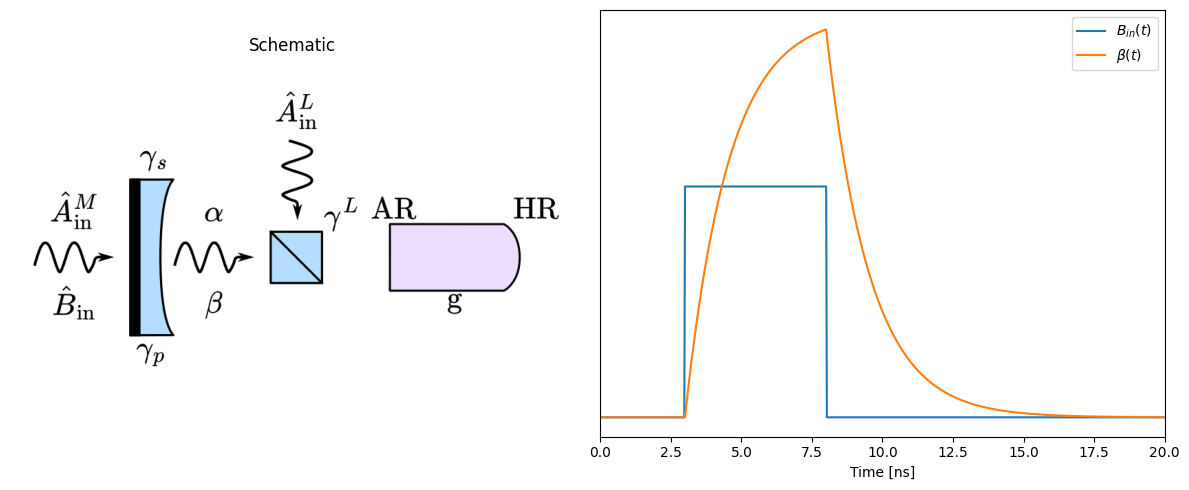

In [161]:
# Load image
img = mpimg.imread("schematics.png")

# Create figure with 2 subplots (side by side)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Left: schematic
axs[0].imshow(img)
axs[0].axis("off")
axs[0].set_title("Schematic")



plt.sca(axs[1])         # set current axis
PlotPulsed.plot_beta()  # will plot on axs[1]

plt.tight_layout()
plt.show()


Important quantities that will describe the squeezing modes are the N and M moment autocorrelation matrices:

\begin{aligned}
    N(t_1,t_2) &= \langle \hat{A}_{\text{out}}^{ M\dagger}(t_1) \hat{A}_{\text{out}}^{ M}(t_2) \rangle = 2\gamma_s^M\Bigg(H_2(t_1,0)H_2(t_2,0) + 2\gamma_s\int_0^{MIN\{t_1,t_2\}} duH_2(t_1,u)H_2(t_2,u)\Bigg) \\
    M(t_1,t_2) &= \langle \hat{A}_{\text{out}}^{ M}(t_1) \hat{A}_{\text{out}}^{ M}(t_2) \rangle = 2\gamma_s^M\Bigg(H_1(t_1,0)H_2(t_2,0) - H_2(t_2,t_1)\mathcal{U}(t_2-t_1) + 2\gamma_s\int_0^{MIN\{t_1,t_2\}} duH_1(t_1,u)H_2(t_2,u)\Bigg)\\
\end{aligned}

Where the functions $H_1(t_1,t_2)$ and $H_2(t_1,t_2)$ are given by:

\begin{aligned}
    H_1(q,p) &=  e^{-\gamma_\text{s}(q-p)}\cdot \cosh\left(g\int_p^q\beta(s)ds\right) \\
    H_2(q,p) &= e^{-\gamma_\text{s}(q-p)}\cdot \sinh\left(g\int_p^q\beta(s)ds\right)
\end{aligned}

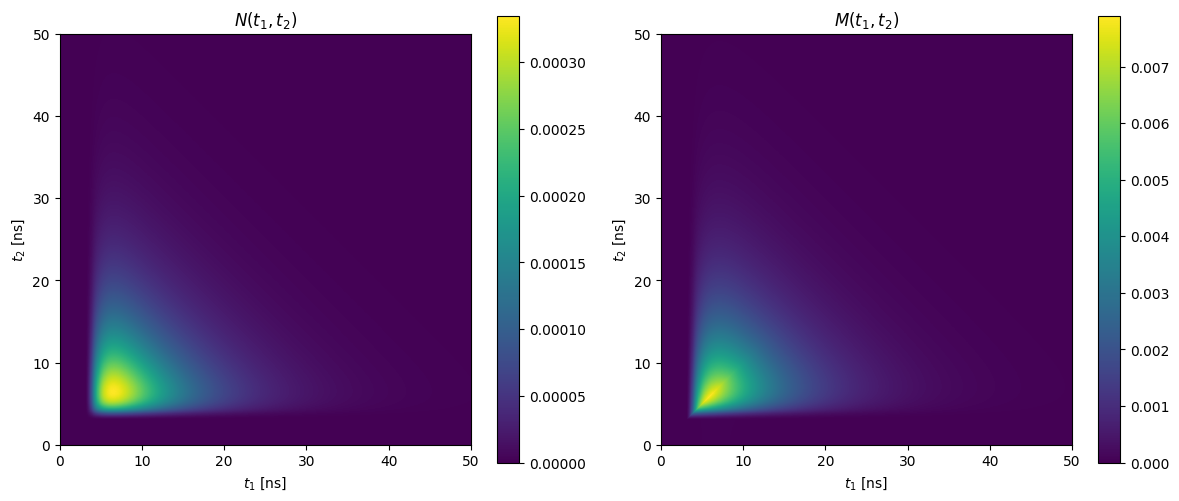

In [ ]:
PlotPulsed.matshow_NM()

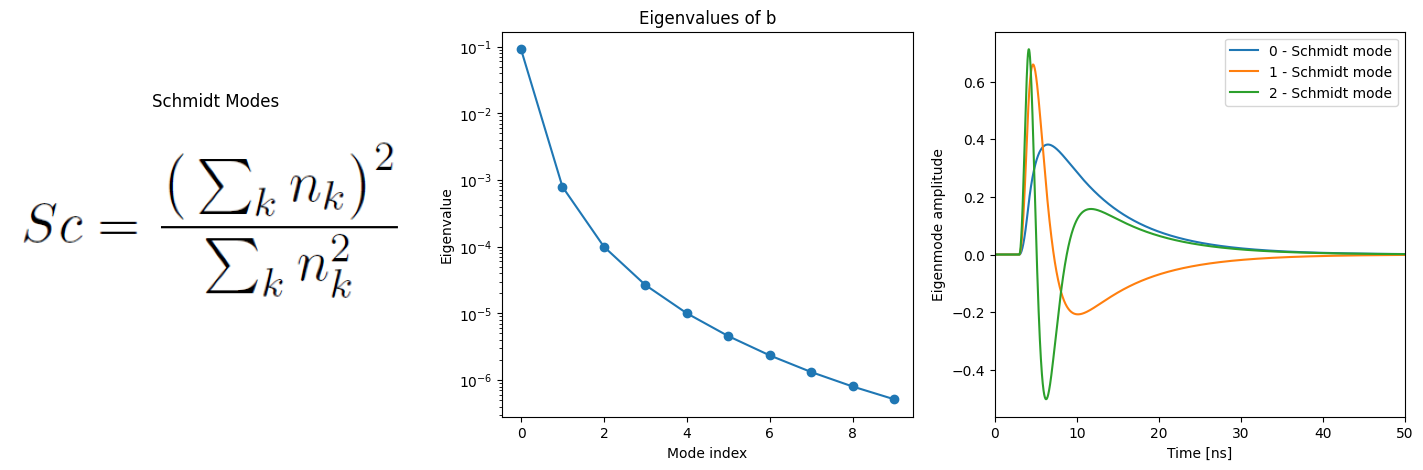

<Figure size 640x480 with 0 Axes>

In [152]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load image
img_schmidt = mpimg.imread("schmidt.png")

# Create figure with 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Left: Schmidt image
axs[0].imshow(img_schmidt)
axs[0].axis("off")
axs[0].set_title("Schmidt Modes")

# Middle: eigenvalues plot
plt.sca(axs[1])
plt.semilogy(b.eigenvalues[::-1], 'o-')
plt.xlabel("Mode index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of b")

# Right: eigenmodes plot
plt.sca(axs[2])
PlotPulsed.plot_eigenmodes(3)  # assumes this uses current axis
axs[2].set_title("Top 3 Eigenmodes")

plt.tight_layout()
plt.show()


  0%|          | 0/101 [00:00<?, ?it/s]C:\Users\ocobo\AppData\Local\Temp\ipykernel_30936\2125943314.py:208: RuntimeWarning: invalid value encountered in log10
  self.squeezing_modes = 10*np.log10((self.first_term - self.second_term)*self.dt + 1)
100%|██████████| 101/101 [00:00<00:00, 135.00it/s]


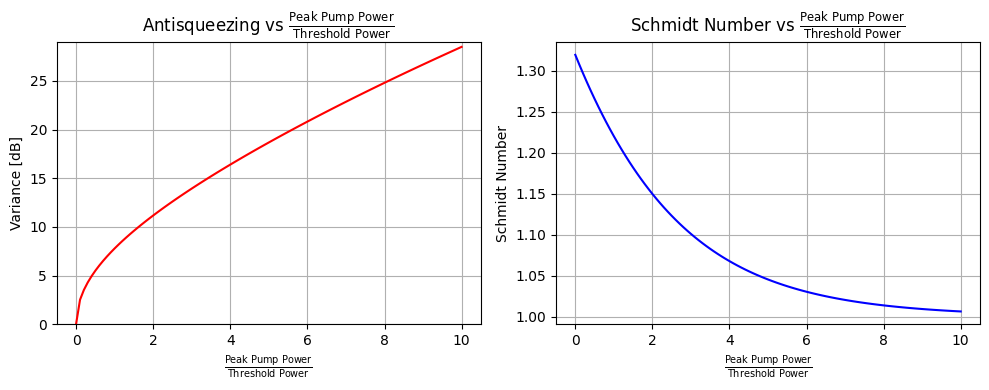

In [153]:
model = TheoreticalPulsed1D(
    pump_power = np.linspace(0.0001, 10, 101),
    pulse_length = 1.6,
    simulation_time = 50,
    N_points = 200,
    R_s = 80.5,
    R_p = 73.4,  # Array parameter
    L=0.2,
    tau_cav = 100e-3
)
model.run()
model.plot()

100%|██████████| 100/100 [00:02<00:00, 48.70it/s]


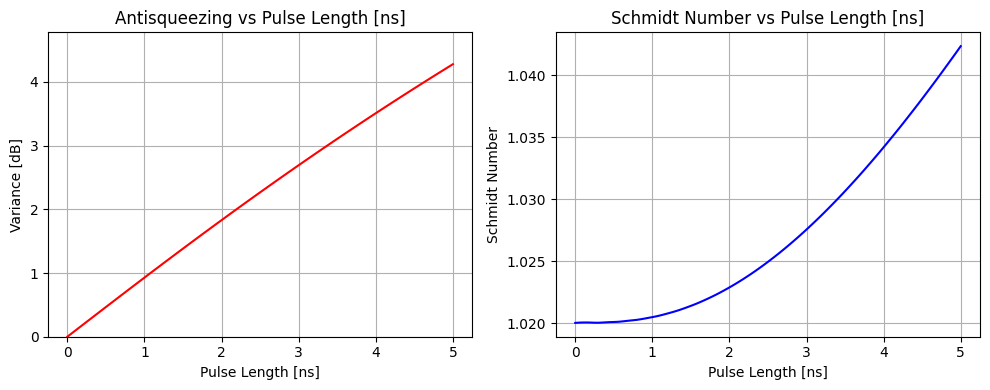

In [156]:
model = TheoreticalPulsed1D(
    pump_power = 1,
    pulse_length = np.linspace(0.001,5,100),
    simulation_time = 100,
    N_points = 400,
    R_s = 94.5,
    R_p = 73.4,  # Array parameter
    L=0.2
)
model.run()
model.plot()

100%|██████████| 26/26 [00:01<00:00, 20.75it/s]


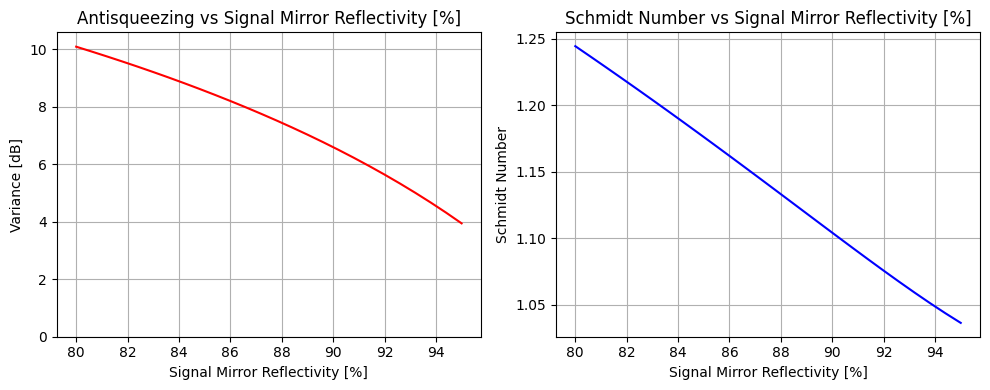

In [157]:
model = TheoreticalPulsed1D(
    pump_power = 1,
    pulse_length = 5,
    simulation_time = 50,
    N_points = 600,
    R_s = np.linspace(80,95,26),
    R_p = 73.4,  # Array parameter
    L=0.2
)
model.run()
model.plot()

100%|██████████| 26/26 [00:01<00:00, 22.39it/s]


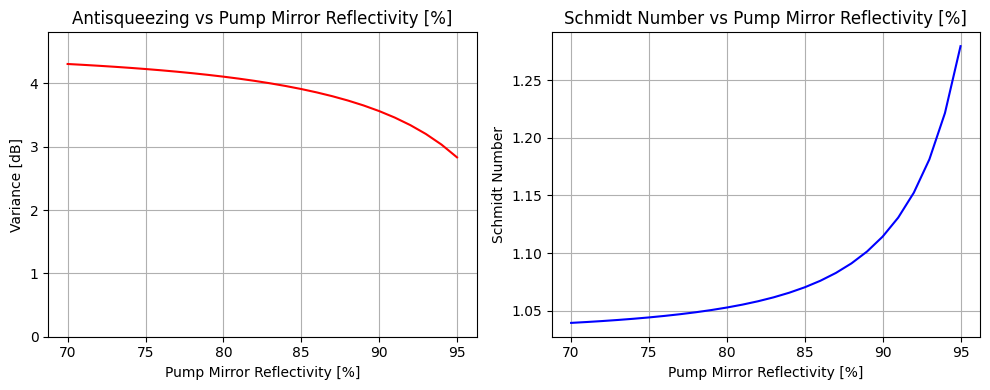

In [158]:
model = TheoreticalPulsed1D(
    pump_power = 1,
    pulse_length = 5,
    simulation_time = 50,
    N_points = 600,
    R_s = 94.5,
    R_p = np.linspace(70,95,26),  # Array parameter
    L=0.2
)
model.run()
model.plot()

100%|██████████| 101/101 [00:04<00:00, 21.83it/s]


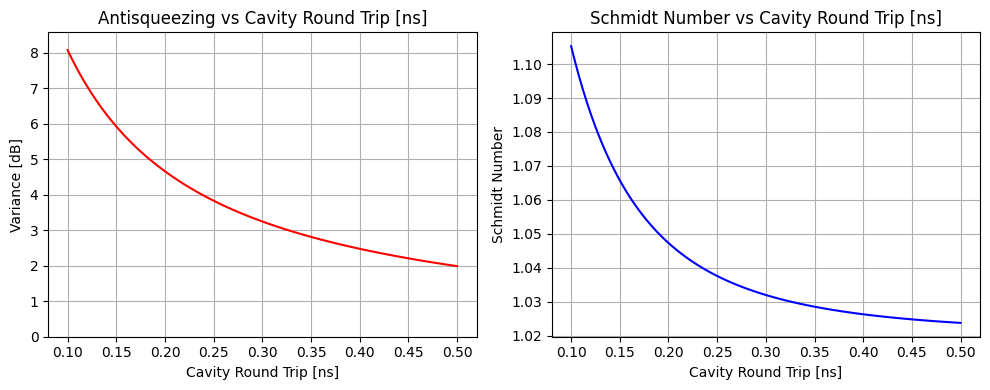

In [159]:
model = TheoreticalPulsed1D(
    pump_power = 1,
    pulse_length = 5,
    simulation_time = 50,
    N_points = 600,
    R_s = 94.5,
    R_p = 73.4,  # Array parameter
    L=0.2,
    tau_cav = np.linspace(100e-3,500e-3, 101)
)
model.run()
model.plot()